# 🎲 GAN Data Augmentation (COCO Format)

This notebook trains a **Conditional DCGAN** and generates synthetic full-scene images with COCO annotations.
The output is directly compatible with `DiceDetectionDataset` used in `3_augmentation_comparison.ipynb`.

**Key Features:**
- Uses local balanced annotations (`Annotations/train_image_balanced.coco.json`) - Zipfian balanced on images
- Downloads images from Roboflow
- Trains conditional DCGAN on dice crops
- Generates full scene images with dice placed on backgrounds
- Outputs COCO-format `_annotations.coco.json` file

## 1. Setup & Installation

In [1]:
# Install required packages
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install roboflow pillow matplotlib seaborn tqdm numpy

Looking in indexes: https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.7/91.7 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 141.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.12.0.88
    Uninstalling opencv-python-headless-4.12.0.88:
      Successfully uninstalled opencv-python-headless-4.12.0.88
  Attempting uninstall: idna
    Found existing installation: idna 3.11
    Uninstalling idna-3.11:
      Successfully uninstalled idna-3.11


In [2]:
# Clone the git repository with the code
import os
if not os.path.exists('Dice-Detection'):
    !git clone https://github.com/Adr44mo/Dice-Detection.git
    %cd Dice-Detection
else:
    %cd Dice-Detection

# Add src to path
import sys
sys.path.append('./src')

Cloning into 'Dice-Detection'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 75 (delta 35), reused 63 (delta 23), pack-reused 0 (from 0)
Receiving objects: 100% (75/75), 1.23 MiB | 17.28 MiB/s, done.
Resolving deltas: 100% (35/35), done.
/content/Dice-Detection


## 2. Import Libraries

In [3]:
import json
import random
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

# Import custom modules from src
from src.gan import (
    Generator,
    Discriminator,
    weights_init,
    generate_dice_image,
    extract_backgrounds,
    create_synthetic_coco_dataset
)
from src.dataset import DiceDetectionDataset  # For verification

# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Using device: cuda
GPU: Tesla T4


## 3. Download Dataset from Roboflow

In [4]:
from roboflow import Roboflow

rf = Roboflow(api_key="kd9lS9tvh5StEQtSA6i9")
project = rf.workspace("workspace-spezm").project("dice-0sexk")
dataset = project.version(2).download("coco")
print(f"Dataset downloaded to: {dataset.location}")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to dice-2 in coco:: 100%|██████████| 1467/1467 [00:00<00:00, 8628.61it/s]

Dataset downloaded to: /content/Dice-Detection/dice-2


## 4. Load Balanced Annotations

We use the local balanced annotations (`train_image_balanced.coco.json`) which contains a Zipfian-balanced subset of images, while using the images downloaded from Roboflow.

In [5]:
# Load balanced annotations from local file
ANNOTATION_FILE_train = 'Annotations/train_zipfian_object_balanced.coco.json'
ANNOTATION_FILE_val = 'Annotations/val_zipfian_object_balanced.coco.json'

IMAGE_BASE_PATH_train = f'{dataset.location}/train'
IMAGE_BASE_PATH_val = f'{dataset.location}/valid'

with open(ANNOTATION_FILE_train, 'r') as f:
    balanced_annotations_train = json.load(f)

with open(ANNOTATION_FILE_val, 'r') as f:
    balanced_annotations_val = json.load(f)

print(f"Loaded balanced annotations from: {ANNOTATION_FILE_train}")
print(f"Images: {len(balanced_annotations_train['images'])}")
print(f"Annotations: {len(balanced_annotations_train['annotations'])}")
print(f"Categories: {len(balanced_annotations_train['categories'])}")

# Extract categories (only numeric dice classes)
categories_train = {cat['id']: cat['name'] for cat in balanced_annotations_train['categories']}
valid_categories_train = {k: v for k, v in categories_train.items() if v.isdigit()}
print(f"\nValid dice categories: {valid_categories_train}")

# Create image lookup
image_id_to_info_train = {
    img['id']: {'file_name': img['file_name'], 'width': img['width'], 'height': img['height']}
    for img in balanced_annotations_train['images']
}

print(f"Loaded balanced annotations from: {ANNOTATION_FILE_val}")
print(f"Images: {len(balanced_annotations_val['images'])}")
print(f"Annotations: {len(balanced_annotations_val['annotations'])}")
print(f"Categories: {len(balanced_annotations_val['categories'])}")

categories_val = {cat['id']: cat['name'] for cat in balanced_annotations_val['categories']}
valid_categories_val = {k: v for k, v in categories_val.items() if v.isdigit()}
print(f"\nValid dice categories: {valid_categories_val}")

image_id_to_info_val = {
    img['id']: {'file_name': img['file_name'], 'width': img['width'], 'height': img['height']}
    for img in balanced_annotations_val['images']
}

Loaded balanced annotations from: Annotations/train_zipfian_object_balanced.coco.json
Images: 481
Annotations: 1219
Categories: 7

Valid dice categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}
Loaded balanced annotations from: Annotations/val_zipfian_object_balanced.coco.json
Images: 85
Annotations: 255
Categories: 7

Valid dice categories: {1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6'}


## 5. Extract Dice Crops

Crop dice from downloaded images using bounding boxes from balanced annotations.

In [7]:
IMG_SIZE = 64
OUTPUT_DIR_TRAIN = 'gan_training_data'
OUTPUT_DIR_VAL = 'gan_validation_data'

os.makedirs(OUTPUT_DIR_TRAIN, exist_ok  =True)
for cat_name in valid_categories_train.values():
    os.makedirs(os.path.join(OUTPUT_DIR_TRAIN, cat_name), exist_ok=True)

os.makedirs(OUTPUT_DIR_VAL, exist_ok  =True)
for cat_name in valid_categories_val.values():
    os.makedirs(os.path.join(OUTPUT_DIR_VAL, cat_name), exist_ok=True)

class_counts_train = Counter()

print("\nCropping dice images from balanced dataset...")

for ann in tqdm(balanced_annotations_train['annotations']):
    category_id = ann['category_id']
    if category_id not in valid_categories_train:
        continue

    image_id = ann['image_id']
    bbox = ann['bbox']
    category_name = valid_categories_train[category_id]
    image_info = image_id_to_info_train.get(image_id)

    if not image_info:
        continue

    image_path = os.path.join(IMAGE_BASE_PATH_train, image_info['file_name'])

    try:
        img = Image.open(image_path).convert('RGB')
        x_min, y_min, width, height = [int(b) for b in bbox]
        x_max, y_max = x_min + width, y_min + height
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img.width, x_max), min(img.height, y_max)

        cropped = img.crop((x_min, y_min, x_max, y_max))
        resized = cropped.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        output_filename = f"{image_id}_{ann['id']}.png"
        output_path = os.path.join(OUTPUT_DIR_TRAIN, category_name, output_filename)
        resized.save(output_path)
        class_counts_train[category_name] += 1
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print("\n✅ Cropping complete!")
for cat in sorted(class_counts_train.keys()):
    print(f"  Class {cat}: {class_counts_train[cat]} images")


class_counts_train_val = Counter()

print("\nCropping dice images from balanced dataset...")

for ann in tqdm(balanced_annotations_val['annotations']):
    category_id = ann['category_id']
    if category_id not in valid_categories_val:
        continue

    image_id = ann['image_id']
    bbox = ann['bbox']
    category_name = valid_categories_val[category_id]
    image_info = image_id_to_info_val.get(image_id)

    if not image_info:
        continue

    image_path = os.path.join(IMAGE_BASE_PATH_val, image_info['file_name'])

    try:
        img = Image.open(image_path).convert('RGB')
        x_min, y_min, width, height = [int(b) for b in bbox]
        x_max, y_max = x_min + width, y_min + height
        x_min, y_min = max(0, x_min), max(0, y_min)
        x_max, y_max = min(img.width, x_max), min(img.height, y_max)

        cropped = img.crop((x_min, y_min, x_max, y_max))
        resized = cropped.resize((IMG_SIZE, IMG_SIZE), Image.LANCZOS)

        output_filename = f"{image_id}_{ann['id']}.png"
        output_path = os.path.join(OUTPUT_DIR_VAL, category_name, output_filename)
        resized.save(output_path)
        class_counts_train_val[category_name] += 1
    except Exception as e:
        print(f"Error processing {image_path}: {e}")

print("\n✅ Cropping complete!")
for cat in sorted(class_counts_train_val.keys()):
    print(f"  Class {cat}: {class_counts_train_val[cat]} images")



Cropping dice images from balanced dataset...


100%|██████████| 1219/1219 [00:03<00:00, 324.06it/s]



✅ Cropping complete!
  Class 1: 109 images
  Class 2: 109 images
  Class 3: 182 images
  Class 4: 182 images
  Class 5: 212 images
  Class 6: 425 images

Cropping dice images from balanced dataset...


100%|██████████| 255/255 [00:01<00:00, 230.30it/s]


✅ Cropping complete!
  Class 1: 28 images
  Class 2: 28 images
  Class 3: 57 images
  Class 4: 57 images
  Class 5: 28 images
  Class 6: 57 images


## 6. GAN Architecture & Hyperparameters

In [13]:
# Hyperparameters
LATENT_DIM = 100
NUM_CLASSES = 6
EMBED_DIM = 50
NGF = 64
NDF = 64
NC = 3
BATCH_SIZE = 32
NUM_EPOCHS = 500
LR = 0.0002
BETA1 = 0.5

print(f"Latent dimension: {LATENT_DIM}")
print(f"Number of classes: {NUM_CLASSES}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Number of epochs: {NUM_EPOCHS}")

Latent dimension: 100
Number of classes: 6
Batch size: 32
Number of epochs: 500


In [9]:
# Initialize models from src.gan
netG = Generator(LATENT_DIM, NUM_CLASSES, EMBED_DIM, NGF, NC).to(device)
netD = Discriminator(NUM_CLASSES, NDF, NC, IMG_SIZE).to(device)

# Apply weight initialization
netG.apply(weights_init)
netD.apply(weights_init)

print(f"Generator params: {sum(p.numel() for p in netG.parameters()):,}")
print(f"Discriminator params: {sum(p.numel() for p in netD.parameters()):,}")

Generator params: 3,986,604
Discriminator params: 2,791,168


## 7. Prepare Dataset & DataLoader

In [11]:
class DiceDataset(Dataset):
    """Dataset for loading cropped dice images for GAN training."""

    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []

        for label_idx, label_name in enumerate(['1', '2', '3', '4', '5', '6']):
            label_dir = os.path.join(root_dir, label_name)
            if os.path.exists(label_dir):
                for img_name in os.listdir(label_dir):
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.samples.append((os.path.join(label_dir, img_name), label_idx))
        print(f"Loaded {len(self.samples)} samples")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transforms
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.CenterCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dice_dataset = DiceDataset(OUTPUT_DIR_TRAIN, transform=transform)
dataloader = DataLoader(dice_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, drop_last=True)

print(f"Number of batches: {len(dataloader)}")

Loaded 1219 samples
Number of batches: 38


## 8. Training

In [14]:
criterion = nn.BCELoss()
optimizerD = optim.Adam(netD.parameters(), lr=LR, betas=(BETA1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=LR, betas=(BETA1, 0.999))

G_losses, D_losses = [], []

print("Starting Training...")
for epoch in range(NUM_EPOCHS):
    epoch_D_loss, epoch_G_loss = 0, 0

    for real_imgs, labels in dataloader:
        real_imgs, labels = real_imgs.to(device), labels.to(device)
        batch_size = real_imgs.size(0)

        real_label = torch.ones(batch_size, device=device) * 0.9
        fake_label = torch.zeros(batch_size, device=device) + 0.1

        # Train Discriminator
        netD.zero_grad()
        output_real = netD(real_imgs, labels)
        errD_real = criterion(output_real, real_label)
        errD_real.backward()

        noise = torch.randn(batch_size, LATENT_DIM, device=device)
        fake_imgs = netG(noise, labels)
        output_fake = netD(fake_imgs.detach(), labels)
        errD_fake = criterion(output_fake, fake_label)
        errD_fake.backward()
        optimizerD.step()

        # Train Generator
        netG.zero_grad()
        output = netD(fake_imgs, labels)
        errG = criterion(output, real_label)
        errG.backward()
        optimizerG.step()

        epoch_D_loss += (errD_real + errD_fake).item()
        epoch_G_loss += errG.item()

    G_losses.append(epoch_G_loss / len(dataloader))
    D_losses.append(epoch_D_loss / len(dataloader))

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"[{epoch+1:3d}/{NUM_EPOCHS}] Loss_D: {D_losses[-1]:.4f} | Loss_G: {G_losses[-1]:.4f}")

print("\n✅ Training complete!")

Starting Training...
[  1/500] Loss_D: 1.7019 | Loss_G: 4.1100
[ 20/500] Loss_D: 0.9350 | Loss_G: 2.6179
[ 40/500] Loss_D: 0.8145 | Loss_G: 2.2688
[ 60/500] Loss_D: 0.8472 | Loss_G: 2.3995
[ 80/500] Loss_D: 0.7875 | Loss_G: 2.3971
[100/500] Loss_D: 0.7351 | Loss_G: 2.2043
[120/500] Loss_D: 0.7534 | Loss_G: 2.3792
[140/500] Loss_D: 0.7594 | Loss_G: 2.2670
[160/500] Loss_D: 0.7419 | Loss_G: 2.2676
[180/500] Loss_D: 0.7550 | Loss_G: 2.3957
[200/500] Loss_D: 0.7370 | Loss_G: 2.4659
[220/500] Loss_D: 0.7664 | Loss_G: 2.3623
[240/500] Loss_D: 0.7097 | Loss_G: 2.2984
[260/500] Loss_D: 0.7070 | Loss_G: 2.2692
[280/500] Loss_D: 0.7011 | Loss_G: 2.2662
[300/500] Loss_D: 0.7230 | Loss_G: 2.3122
[320/500] Loss_D: 0.7174 | Loss_G: 2.2521
[340/500] Loss_D: 0.7249 | Loss_G: 2.3090
[360/500] Loss_D: 0.7038 | Loss_G: 2.2174
[380/500] Loss_D: 0.7027 | Loss_G: 2.2238
[400/500] Loss_D: 0.7381 | Loss_G: 2.2848
[420/500] Loss_D: 0.7123 | Loss_G: 2.1828
[440/500] Loss_D: 0.7105 | Loss_G: 2.2739
[460/500] Los

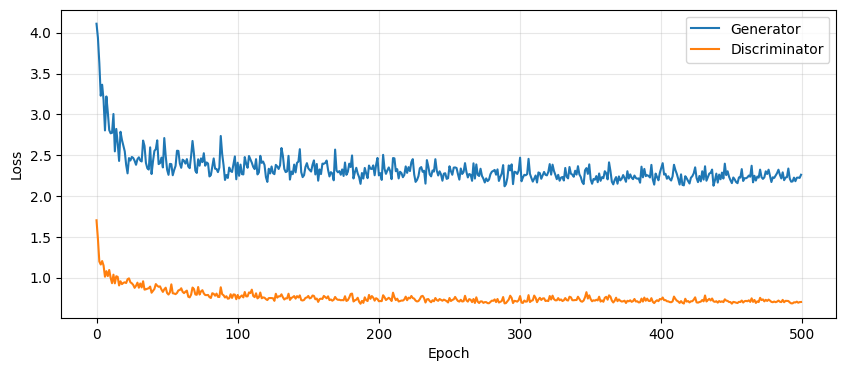

In [15]:
# Plot training losses
plt.figure(figsize=(10, 4))
plt.plot(G_losses, label="Generator")
plt.plot(D_losses, label="Discriminator")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('training_losses.png', dpi=150)
plt.show()

## 9. Generate COCO-Format Dataset

Create full scene images with dice on backgrounds and COCO annotations using functions from `src.gan`.

In [22]:
# Extract background images from downloaded dataset
BACKGROUND_DIR_Train = 'backgrounds_train'
BACKGROUND_DIR_Val = 'backgrounds_val'

train_images_dir = f'{dataset.location}/train'
val_images_dir = f'{dataset.location}/valid'

print("Extracting background samples from training images...")
bg_count = extract_backgrounds(train_images_dir, BACKGROUND_DIR_Train, num_backgrounds=50)
print(f"Extracted {bg_count} background images")

print("Extracting background samples from validation images...")
bg_count = extract_backgrounds(val_images_dir, BACKGROUND_DIR_Val, num_backgrounds=50)
print(f"Extracted {bg_count} background images")

Extracting background samples from training images...
Extracted 50 background images
Extracting background samples from validation images...
Extracted 50 background images


In [ ]:
# Configuration for synthetic dataset generation
SYNTHETIC_COCO_DIR = 'synthetic_coco_dataset'

# Calculate images needed per class for balancing in training set
current_counts_train = {str(i): class_counts_train.get(str(i), 0) for i in range(1, 7)}
target_count_train = max(current_counts_train.values())
images_to_generate_train = {k: max(0, target_count_train - v) for k, v in current_counts_train.items()}

print(f"Current class distribution: {current_counts_train}")
print(f"Target count per class: {target_count_train}")

# We'll add synthetic dice to existing images to avoid overlap issues
num_images_to_augment_train = len(balanced_annotations_train['images'])
print(f"Will add synthetic dice to {num_images_to_augment_train} existing images")

# Generation config - ADD synthetic dice to existing images
gen_config = {
    'scene_size': (640, 640),
    'dice_size_range': (60, 120),
    'dice_per_image': (1, 3),  # Add 1-3 dice per image
    'num_images': num_images_to_augment_train,
    'merge_with_original': True,  # Merge with original annotations
    'add_to_existing_images': True  # Add to existing images instead of creating new ones
}

# Generate augmented COCO dataset (merges with original)
print("\n=== Generating TRAINING dataset ===")
coco_data_train = create_synthetic_coco_dataset(
    generator=netG,
    background_dir=BACKGROUND_DIR_Train,
    output_dir=SYNTHETIC_COCO_DIR,
    config=gen_config,
    device=device,
    class_counts=current_counts_train,
    latent_dim=LATENT_DIM,
    original_annotations=balanced_annotations_train,  # Pass original annotations
    original_image_dir=IMAGE_BASE_PATH_train,  # Pass original image directory
    split='train'  # Specify split name
)

# Calculate images needed per class for balancing in validation set
current_counts_val = {str(i): class_counts_train_val.get(str(i), 0) for i in range(1, 7)}
target_count_val = max(current_counts_val.values())
images_to_generate_val = {k: max(0, target_count_val - v) for k, v in current_counts_val.items()}

print(f"\nCurrent class distribution: {current_counts_val}")
print(f"Target count per class: {target_count_val}")

# We'll add synthetic dice to existing images to avoid overlap issues
num_images_to_augment_val = len(balanced_annotations_val['images'])
print(f"Will add synthetic dice to {num_images_to_augment_val} existing images")

# Generation config - ADD synthetic dice to existing images
gen_config_val = {
    'scene_size': (640, 640),
    'dice_size_range': (60, 120),
    'dice_per_image': (1, 3),  # Add 1-3 dice per image
    'num_images': num_images_to_augment_val,
    'merge_with_original': True,  # Merge with original annotations
    'add_to_existing_images': True  # Add to existing images instead of creating new ones
}

# Generate augmented COCO dataset (merges with original)
print("\n=== Generating VALIDATION dataset ===")
coco_data_val = create_synthetic_coco_dataset(
    generator=netG,
    background_dir=BACKGROUND_DIR_Val,
    output_dir=SYNTHETIC_COCO_DIR,
    config=gen_config_val,
    device=device,
    class_counts=current_counts_val,
    latent_dim=LATENT_DIM,
    original_annotations=balanced_annotations_val,  # Pass original annotations
    original_image_dir=IMAGE_BASE_PATH_val,  # Pass original image directory
    split='valid'  # Specify split name
)

Current class distribution: {'1': 109, '2': 109, '3': 182, '4': 182, '5': 212, '6': 425}
Target count per class: 425
Will add synthetic dice to 481 existing images
Merging with original annotations...
Starting from image_id=1226, annotation_id=2788
Generating 481 synthetic scenes...
Adding synthetic dice to existing images...


100%|██████████| 481/481 [00:03<00:00, 147.21it/s]



✅ Generated dataset with 481 total images and 2166 total annotations

Synthetic dice added per class:
  Class 1: 204 dice
  Class 2: 211 dice
  Class 3: 154 dice
  Class 4: 201 dice
  Class 5: 177 dice
  Class 6: 0 dice
Current class distribution: {'1': 28, '2': 28, '3': 57, '4': 57, '5': 28, '6': 57}
Target count per class: 57
Will add synthetic dice to 85 existing images
Merging with original annotations...
Starting from image_id=127, annotation_id=381
Generating 85 synthetic scenes...
Adding synthetic dice to existing images...


100%|██████████| 85/85 [00:00<00:00, 149.49it/s]


✅ Generated dataset with 85 total images and 416 total annotations

Synthetic dice added per class:
  Class 1: 40 dice
  Class 2: 37 dice
  Class 3: 10 dice
  Class 4: 11 dice
  Class 5: 46 dice
  Class 6: 17 dice


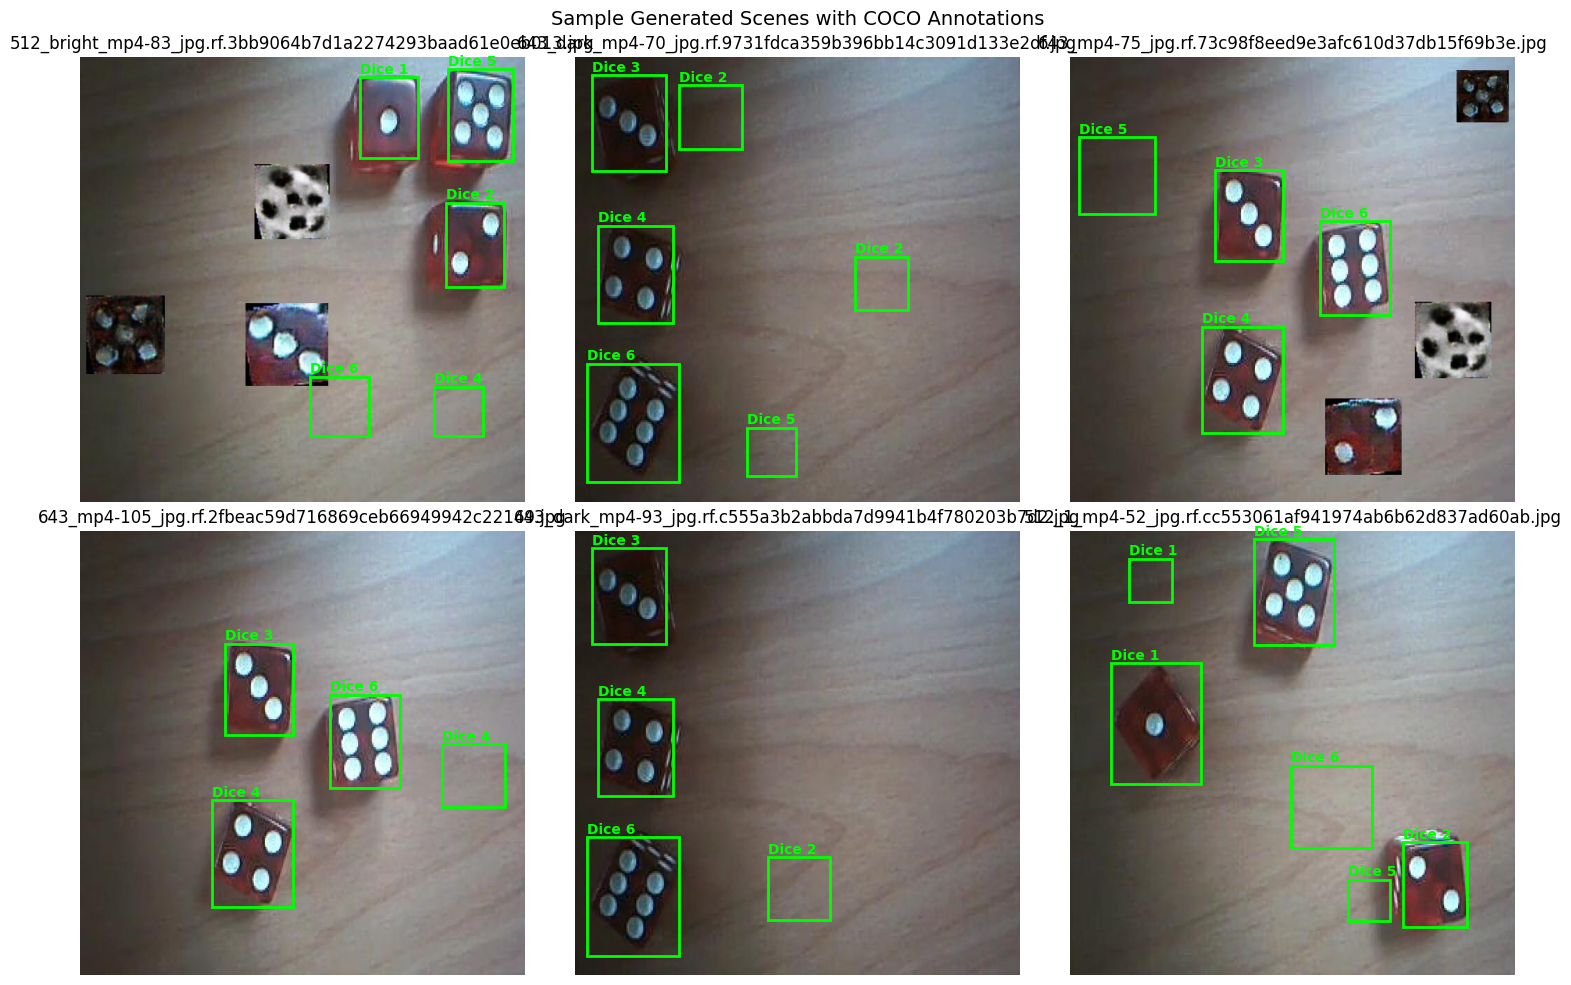

In [ ]:
# Visualize sample generated scenes from TRAINING set
import matplotlib.patches as patches

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = random.sample(coco_data_train['images'], min(6, len(coco_data_train['images'])))

for ax, img_info in zip(axes, sample_images):
    img_path = os.path.join(SYNTHETIC_COCO_DIR, 'train', img_info['file_name'])
    img = Image.open(img_path)
    ax.imshow(img)

    # Draw bounding boxes
    for ann in coco_data_train['annotations']:
        if ann['image_id'] == img_info['id']:
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Dice {ann['category_id']}", color='lime', fontsize=10, weight='bold')

    ax.axis('off')
    ax.set_title(img_info['file_name'])

plt.suptitle('Sample Generated Training Scenes with COCO Annotations', fontsize=14)
plt.tight_layout()
plt.savefig('sample_coco_scenes_train.png', dpi=150)
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'synthetic_coco_dataset/val/643_mp4-105_jpg.rf.2fbeac59d716869ceb66949942c22149.jpg'

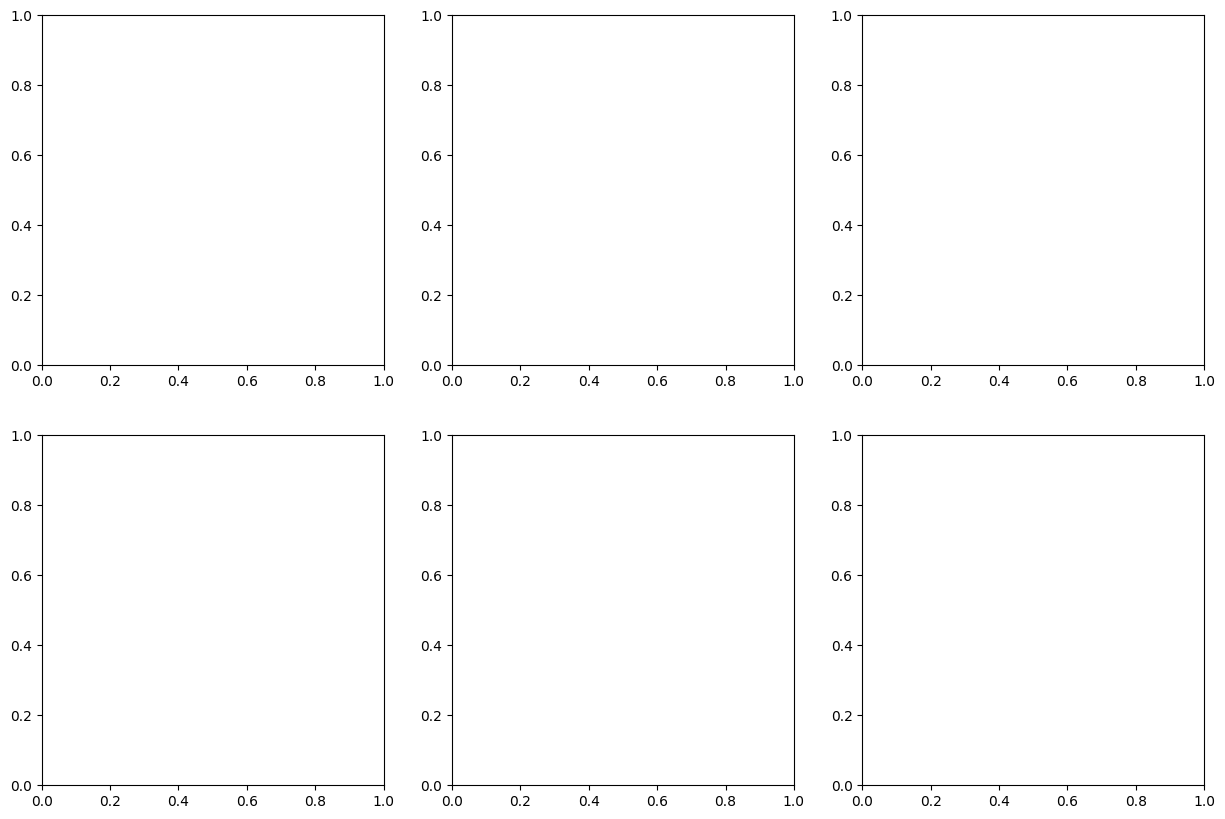

In [ ]:
# Visualize sample generated scenes from VALIDATION set
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

sample_images = random.sample(coco_data_val['images'], min(6, len(coco_data_val['images'])))

for ax, img_info in zip(axes, sample_images):
    img_path = os.path.join(SYNTHETIC_COCO_DIR, 'valid', img_info['file_name'])
    img = Image.open(img_path)
    ax.imshow(img)

    # Draw bounding boxes
    for ann in coco_data_val['annotations']:
        if ann['image_id'] == img_info['id']:
            x, y, w, h = ann['bbox']
            rect = patches.Rectangle((x, y), w, h, linewidth=2, edgecolor='lime', facecolor='none')
            ax.add_patch(rect)
            ax.text(x, y - 5, f"Dice {ann['category_id']}", color='lime', fontsize=10, weight='bold')

    ax.axis('off')
    ax.set_title(img_info['file_name'])

plt.suptitle('Sample Generated Validation Scenes with COCO Annotations', fontsize=14)
plt.tight_layout()
plt.savefig('sample_coco_scenes_val.png', dpi=150)
plt.show()

## 10. Verify Compatibility with DiceDetectionDataset

In [ ]:
# Test loading with DiceDetectionDataset from src
print("=== Testing TRAINING dataset ===")
try:
    synthetic_dataset_train = DiceDetectionDataset(
        root_dir=os.path.join(SYNTHETIC_COCO_DIR, 'train'),
        annotation_file='_annotations.coco.json',
        split='train'
    )

    print(f"✅ Successfully loaded synthetic training dataset!")
    print(f"   Number of images: {len(synthetic_dataset_train)}")
    print(f"   Number of classes: {synthetic_dataset_train.num_classes}")
    print(f"   Class distribution: {synthetic_dataset_train.get_class_distribution()}")

    # Test getting an item
    image, target = synthetic_dataset_train[0]
    print(f"\n   Sample image shape: {image.shape}")
    print(f"   Sample boxes: {target['boxes'].shape}")
    print(f"   Sample labels: {target['labels']}")

except Exception as e:
    print(f"❌ Could not test with DiceDetectionDataset: {e}")
    print("The dataset structure is still COCO-compatible.")


print("\n=== Testing VALIDATION dataset ===")
try:
    synthetic_dataset_val = DiceDetectionDataset(
        root_dir=os.path.join(SYNTHETIC_COCO_DIR, 'valid'),
        annotation_file='_annotations.coco.json',
        split='valid'
    )

    print(f"✅ Successfully loaded synthetic validation dataset!")
    print(f"   Number of images: {len(synthetic_dataset_val)}")
    print(f"   Number of classes: {synthetic_dataset_val.num_classes}")
    print(f"   Class distribution: {synthetic_dataset_val.get_class_distribution()}")

    # Test getting an item
    image, target = synthetic_dataset_val[0]
    print(f"\n   Sample image shape: {image.shape}")
    print(f"   Sample boxes: {target['boxes'].shape}")
    print(f"   Sample labels: {target['labels']}")

except Exception as e:
    print(f"❌ Could not test with DiceDetectionDataset: {e}")
    print("The dataset structure is still COCO-compatible.")

✅ Successfully loaded synthetic dataset!
   Number of images: 85
   Number of classes: 7
   Class distribution: {'1': 57, '2': 51, '3': 57, '4': 57, '5': 52, '6': 57}

   Sample image shape: torch.Size([3, 640, 640])
   Sample boxes: torch.Size([4, 4])
   Sample labels: tensor([1, 5, 2, 5])
Could not test with SyntheticCOCODataset: name 'SyntheticCOCODataset' is not defined
The dataset structure is still COCO-compatible.


## 11. Save Model

In [ ]:
MODEL_DIR = 'gan_models'
os.makedirs(MODEL_DIR, exist_ok=True)

torch.save({
    'generator_state_dict': netG.state_dict(),
    'discriminator_state_dict': netD.state_dict(),
    'epoch': NUM_EPOCHS,
    'G_losses': G_losses,
    'D_losses': D_losses,
}, os.path.join(MODEL_DIR, 'conditional_dcgan_dice.pth'))

print(f"✅ Model saved to {MODEL_DIR}/conditional_dcgan_dice.pth")

✅ Model saved to gan_models/conditional_dcgan_dice.pth


## 🚀 Summary

This notebook:
1. ✅ Downloaded images from Roboflow
2. ✅ Used local balanced annotations (`Annotations/train_image_balanced.coco.json`) - Zipfian balanced on images
3. ✅ Extracted dice crops from balanced subset
4. ✅ Trained Conditional DCGAN on dice crops (500 epochs for better quality)
5. ✅ Added synthetic dice to existing images (avoiding overlap with original dice)
6. ✅ Merged original and synthetic annotations into unified dataset

**Key improvements:**
- 🎯 Original annotations are preserved and merged with synthetic ones
- 🚫 Synthetic dice avoid overlapping with existing dice in images
- 📈 Longer training (500 epochs) for higher quality GAN output

**Output files:**
- `synthetic_coco_dataset/train/` - Original + augmented images
- `synthetic_coco_dataset/train/_annotations.coco.json` - Merged COCO annotations (original + synthetic)
- `gan_models/conditional_dcgan_dice.pth` - Trained GAN

**Usage in other notebooks:**
```python
from src.dataset import DiceDetectionDataset

# This now contains BOTH original and synthetic dice!
augmented_train = DiceDetectionDataset(
    root_dir='synthetic_coco_dataset/train',
    annotation_file='_annotations.coco.json',
    split='train'
)